# Loading and Processing Data

### Set up dataframe with category and image urls

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage import data, io, filters

import os
data = []
!cp -r "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT" "./"
os.makedirs("./images") 
os.makedirs("./masks") 

SHAPE = (250,250)
for dirname, _, filenames in os.walk("./Dataset_BUSI_with_GT"):
    if "normal" not in dirname:
        for filename in filenames:
            if "mask" not in filename:
                d1 = dirname.split('/')[2]
                d2 = os.path.join('./images', filename)
                d3 = os.path.join('./masks',filename)
                os.replace(dirname+"/"+filename.replace('.png','') + ("_mask.png"), "./masks/" + filename)
                os.replace(dirname+"/"+filename, "./images/" + filename)
                #print(dirname+"/"+filename,filename)

                data.append([d1,d2,d3])
df = pd.DataFrame(data, columns=['category','image','mask'])
df

category                         image                         mask
0       benign     ./images/benign (315).png     ./masks/benign (315).png
1       benign     ./images/benign (274).png     ./masks/benign (274).png
2       benign     ./images/benign (108).png     ./masks/benign (108).png
3       benign     ./images/benign (386).png     ./masks/benign (386).png
4       benign     ./images/benign (283).png     ./masks/benign (283).png
..         ...                           ...                          ...
642  malignant  ./images/malignant (143).png  ./masks/malignant (143).png
643  malignant  ./images/malignant (100).png  ./masks/malignant (100).png
644  malignant   ./images/malignant (15).png   ./masks/malignant (15).png
645  malignant   ./images/malignant (44).png   ./masks/malignant (44).png
646  malignant  ./images/malignant (165).png  ./masks/malignant (165).png

[647 rows x 3 columns]

In [2]:
IMAGE_SIZE = (300,300)

for i in df.itertuples():
    img = io.imread(i.image)
    mask = io.imread(i.mask) 

Index(['category', 'image', 'mask'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


2023-02-16 17:24:39.455509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 17:24:39.550002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 17:24:39.551098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 17:24:39.557755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

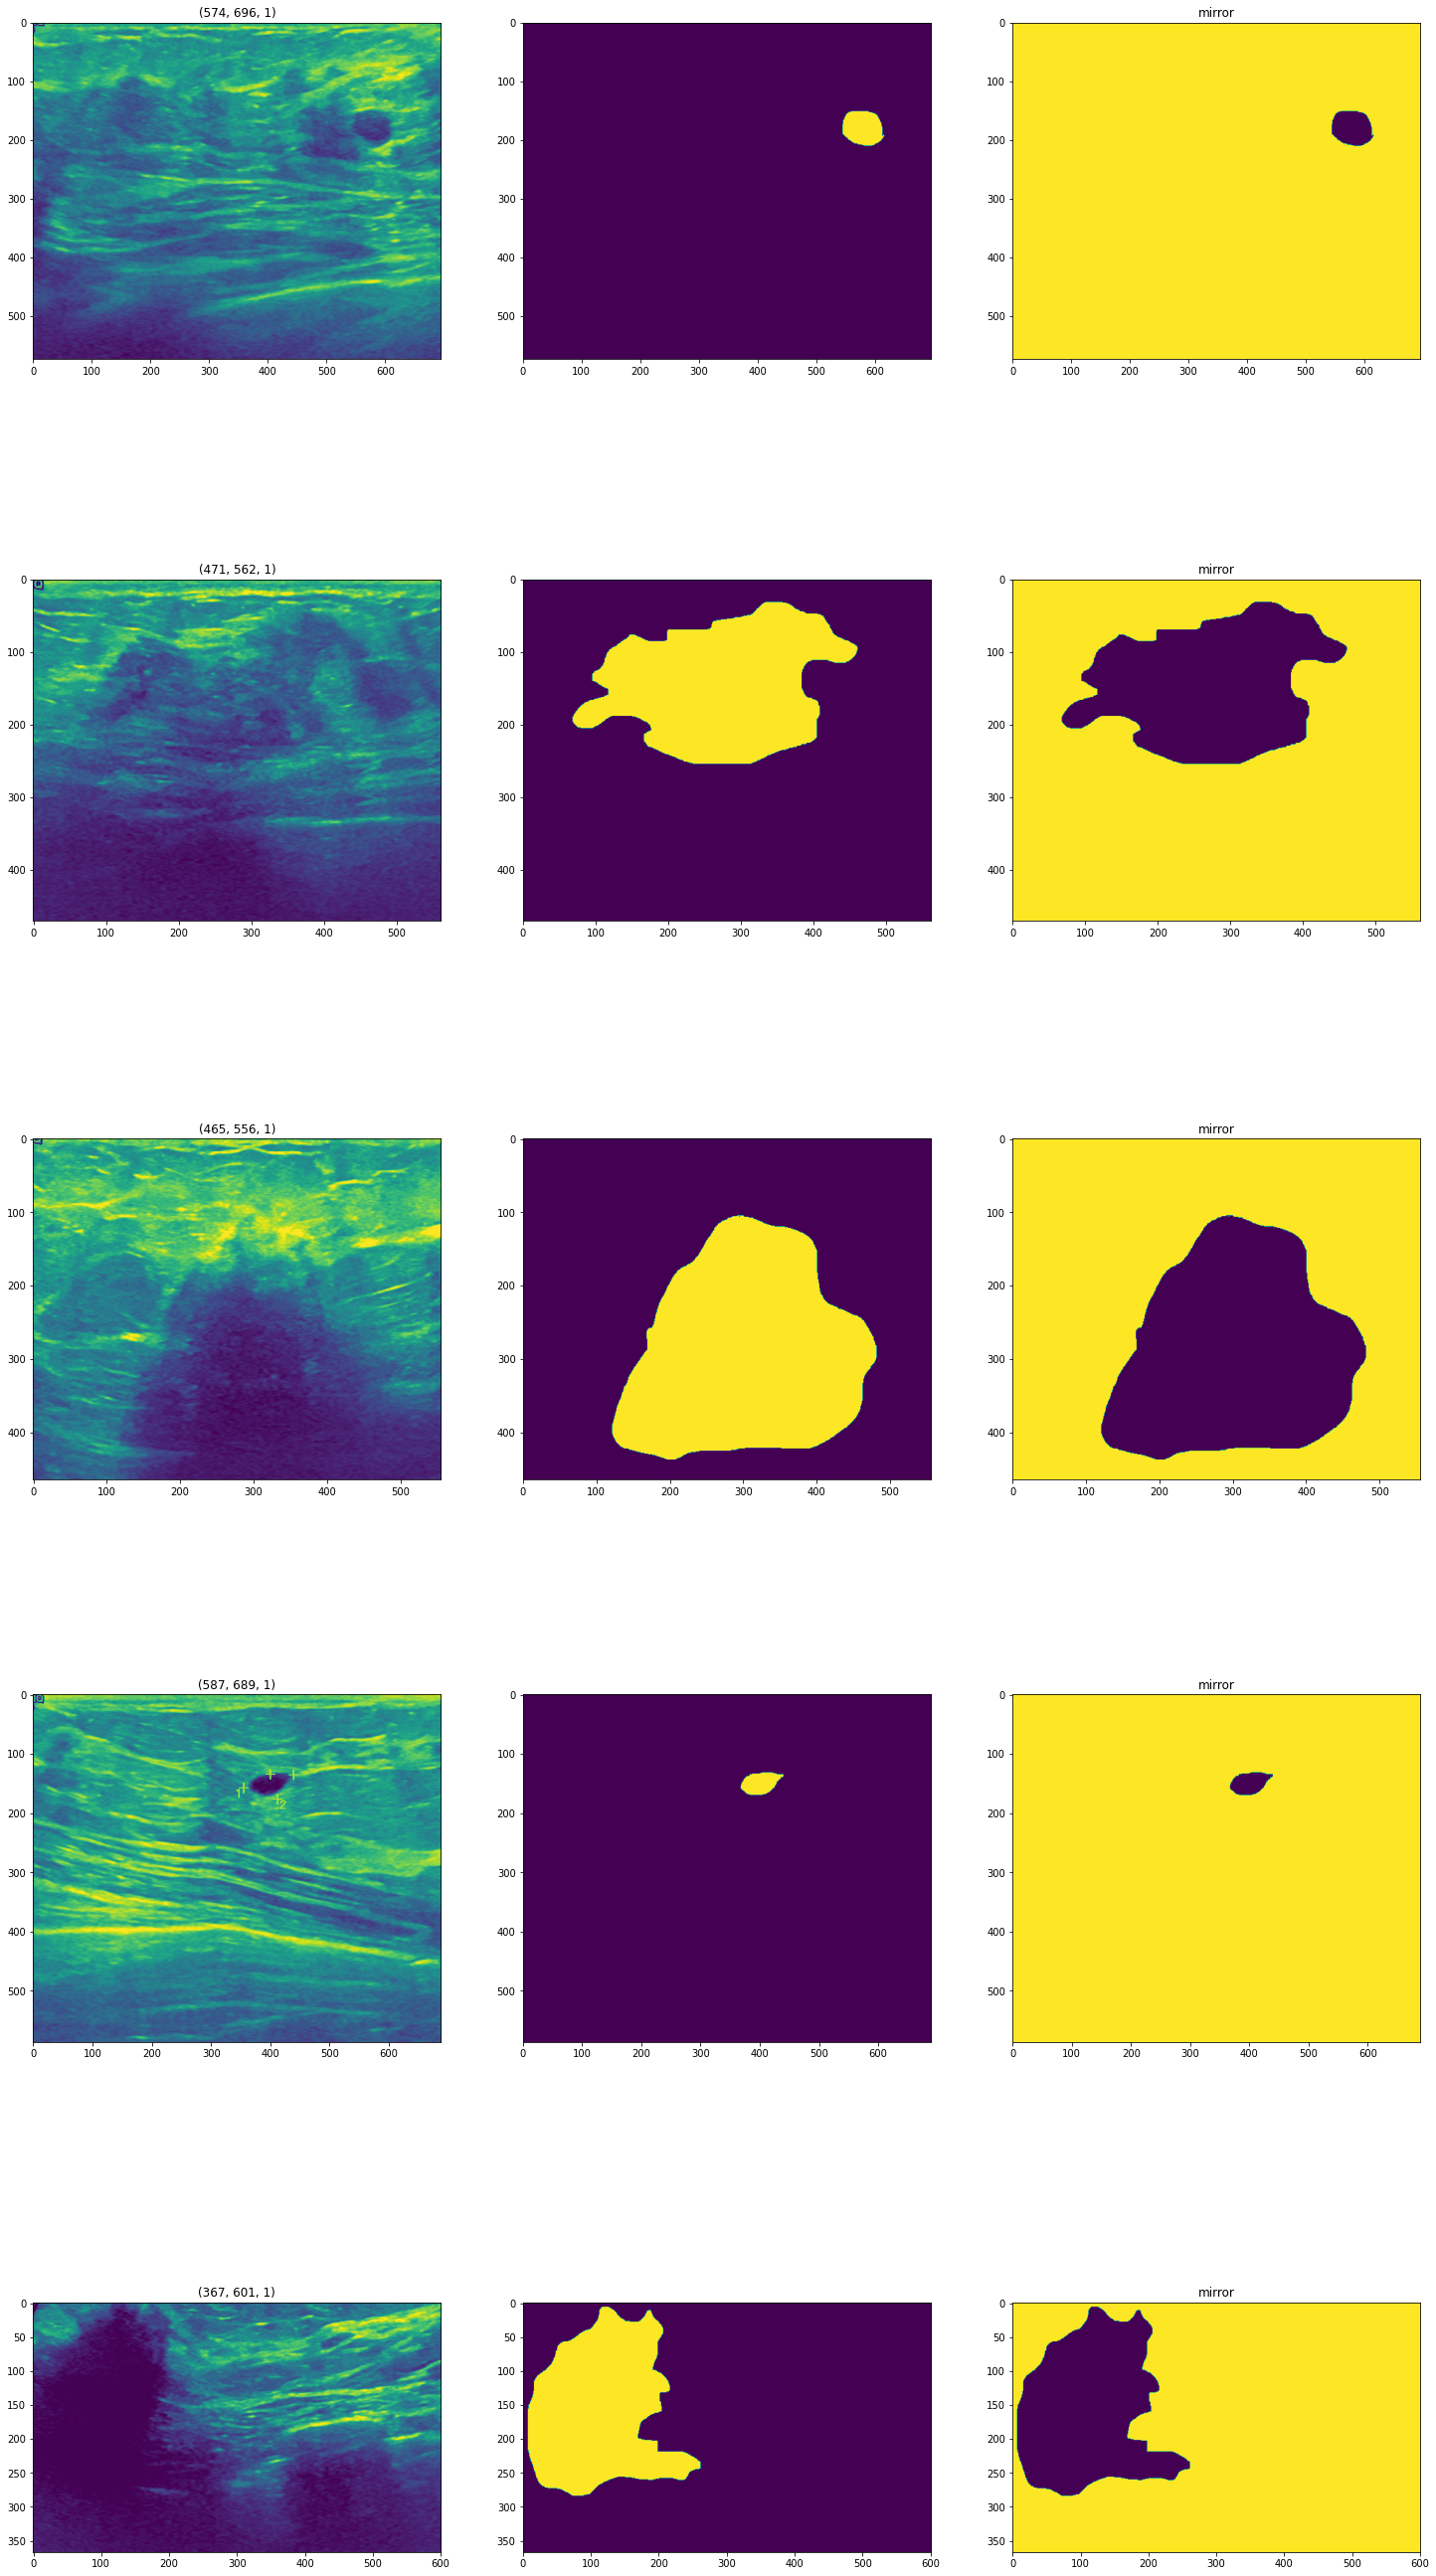

In [3]:
#Visualizaing the x-images with their corresponding masks
IMAGE_SIZE = (250,250)
n=5
samples = df.sample(n=n, random_state=1)
print(samples.columns)
print(type(samples))
fig, axs = plt.subplots(n,3,figsize=(n*5,n*10))

for idx,i in enumerate(samples.itertuples()):
    mask = tf.io.read_file(i.mask)
    img = tf.io.read_file(i.image)
    
    img = tf.image.decode_jpeg(img, channels=1)
    mask = tf.image.decode_jpeg(mask, channels=1)
    
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mirror = (mask+1)%2
    reshaped = tf.image.resize(img, size=[SHAPE[0],SHAPE[1]])    
    axs[idx,0].set_title(str(img.shape))
    axs[idx,0].imshow(img)
    axs[idx,1].imshow(mask)
    axs[idx,2].set_title(str("mirror"))
    axs[idx,2].imshow(mirror)    

In [4]:
#edit this stuff
#COVERTING image numpy form type into FLOAT
#Resizing image
def process_img(file_path,shape=SHAPE,ismask=False):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[shape[0],shape[1]])
    if ismask:
        mirror = (img+1)%2
        return tf.concat([img,mirror],2)
    return img

## U-net

### Segmentation model


In [5]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, Input,UpSampling2D,Concatenate, MaxPooling2D,ReLU, Conv2D,Concatenate,Conv2DTranspose,Cropping2D,Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import SGD

class U_Net():
    def __init__(self, inp=(572, 572, 1),min_filter=64,max_filter=1024, optimizer='Adam',loss=BinaryCrossentropy(), metrics = ['accuracy',AUC()]):
        self.max_filter = max_filter
        self.min_filter = min_filter
        self.img_inp = Input(shape = inp)
        down,cac,down_list = self.downsample()
        lower,down_list = self.contracting_path(down,down_list)
        upper,cac2 = self.upsample(lower,down_list)
        out = Conv2D(2,(1), activation="softmax", name='output')(upper)
        self.out = out
        self.model = keras.Model(inputs=self.img_inp, outputs=self.out)
        
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=0.01, momentum=0.9,  name="SGD"
        )
        self.model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    
    def downsample(self):
        k = self.min_filter

        down_list = []
        res = self.img_inp
        while k < self.max_filter:
            res = Conv2D(k,(3,3))(res)
            res = ReLU()(res)
            #rest = Dropout(0.3)(res)
            res = Conv2D(k,(3,3))(res)
            res = ReLU()(res)
            #rest = Dropout(0.3)(res)
            down_list.append(res)
            cac = res
            res = MaxPooling2D(pool_size=(2, 2),strides=2)(res)
            curr = res
            k*=2
        return res,cac,down_list
    
    def upsample(self,res,down_list):
        k = self.max_filter
        i=0
        while k > self.min_filter:
            res = Conv2D(k/2,(3,3))(res)
            res = ReLU()(res)
            #rest = Dropout(0.3)(res)
            k/=2
            
            if k > self.min_filter:
                res = Conv2D(k/2,(3,3))(res)
                res = ReLU()(res)
                #rest = Dropout(0.3)(res)
                res = UpSampling2D((2,2))(res)
                left = down_list.pop()
                res = self.crop_and_conc(left,res)
                i+=1
            else:
                res = Conv2D(k,(3,3))(res)
                res = ReLU()(res)
                #rest = Dropout(0.3)(res)
            cac = res
            curr = res
        return res,cac
    
    def contracting_path(self,down,down_list):
        res = Conv2D(self.max_filter,(3,3))(down)
        res = ReLU()(res)
        #rest = Dropout(0.3)(res)
        res = Conv2D(self.max_filter/2,(3,3))(res)
        res = ReLU()(res)
        #rest = Dropout(0.3)(res)
        res = UpSampling2D((2,2))(res)
        left = down_list.pop()
        res = self.crop_and_conc(left,res)
        return res,down_list
    
    
    def crop_and_conc(self,left,right):
        left = Cropping2D(cropping=int((left.shape[1]-right.shape[1])/2))(left)
        right = Concatenate()([left,right])
        return right

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 298, 298, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 298, 298, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 296, 296, 64) 36928       re_lu[0][0]                      
______________________________________________________________________________________________

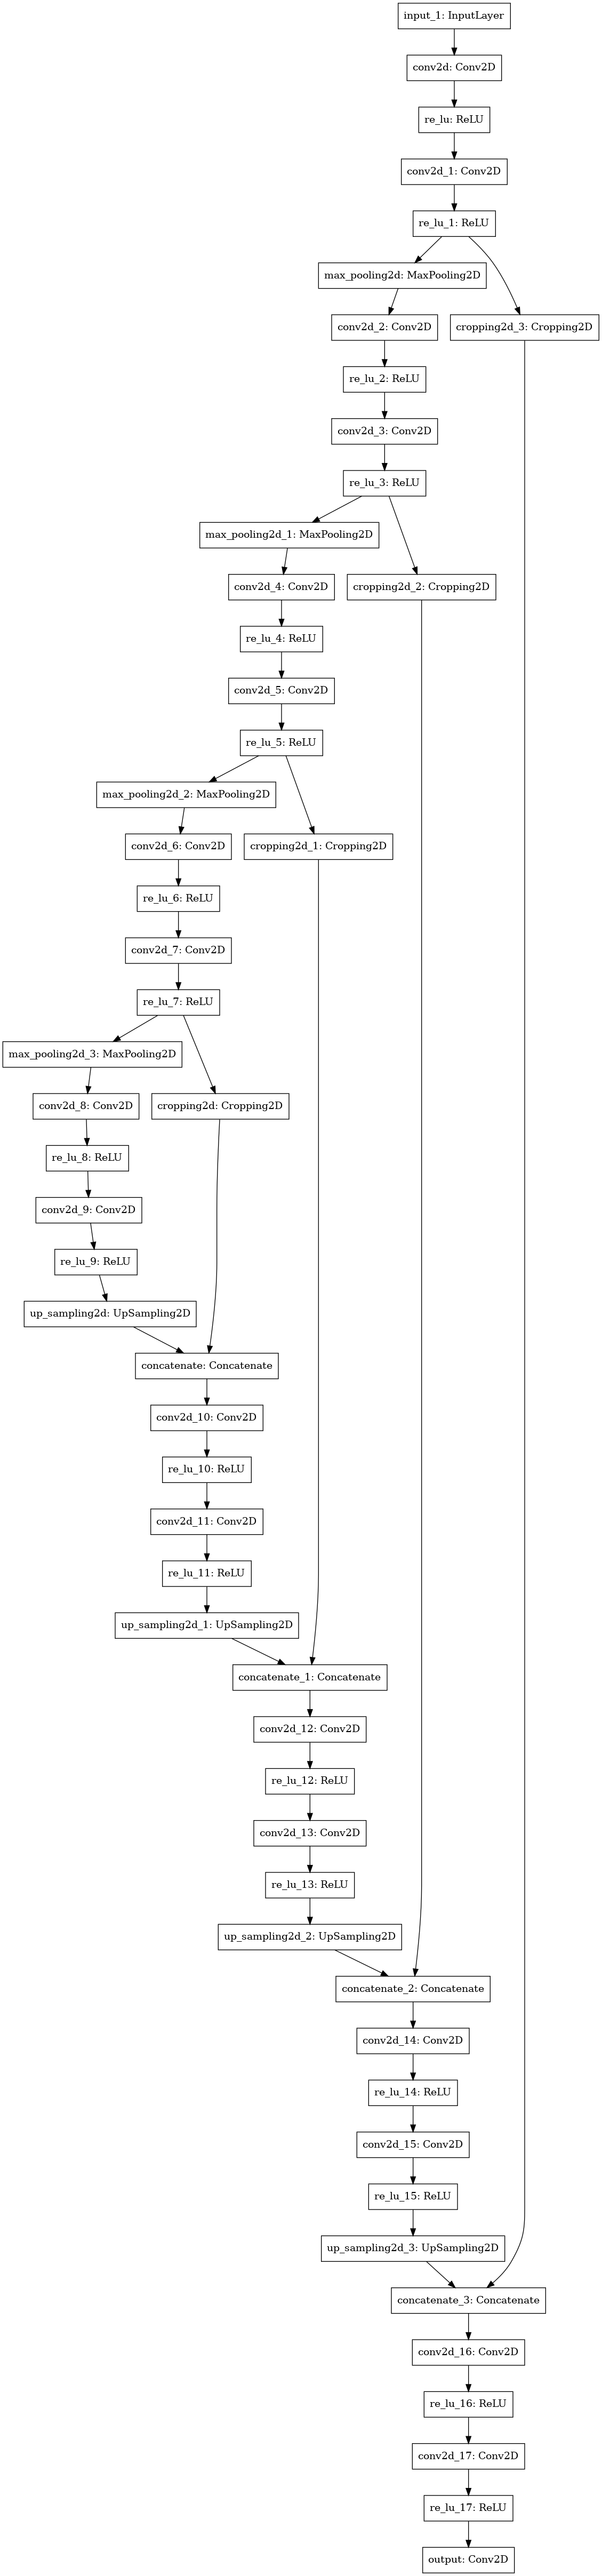

In [6]:
#Visualizing UNET segmentation model layers
shape = (300,300,1)
model = U_Net(inp=shape)
model.model.summary()
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model.model, to_file=dot_img_file, show_shapes=False)

In [7]:
from glob import glob
#retrieving files and then creating a dataset in (file_ds) to store them
x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])

#Preprocessing each image and then passing it to the neural network
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

#prints shape of output layer of (File_ds)
print(type(files_ds))

    
batch_size = 32
LR = 1e-2
epochs = 75
#Fitting(training) our segmentation model
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

(116, 116, 2)
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Epoch 1/75


2023-02-16 17:26:18.772116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-16 17:26:20.897530: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


647/647 [==============================] - 29s 31ms/step - loss: 0.3125 - accuracy: 0.9070 - auc: 0.9235
Epoch 2/75
647/647 [==============================] - 20s 31ms/step - loss: 0.3011 - accuracy: 0.9083 - auc: 0.9258
Epoch 3/75
647/647 [==============================] - 21s 32ms/step - loss: 0.2999 - accuracy: 0.9083 - auc: 0.9266
Epoch 4/75
647/647 [==============================] - 20s 31ms/step - loss: 0.2992 - accuracy: 0.9083 - auc: 0.9266
Epoch 5/75
647/647 [==============================] - 21s 32ms/step - loss: 0.2989 - accuracy: 0.9083 - auc: 0.9266
Epoch 6/75
647/647 [==============================] - 20s 31ms/step - loss: 0.2987 - accuracy: 0.9083 - auc: 0.9265
Epoch 7/75
647/647 [==============================] - 20s 32ms/step - loss: 0.2982 - accuracy: 0.9083 - auc: 0.9268
Epoch 8/75
647/647 [==============================] - 20s 31ms/step - loss: 0.2967 - accuracy: 0.9083 - auc: 0.9291
Epoch 9/75
647/647 [==============================] - 20s 32ms/step - loss: 0.2931 

### Performance of UNET Segementation model

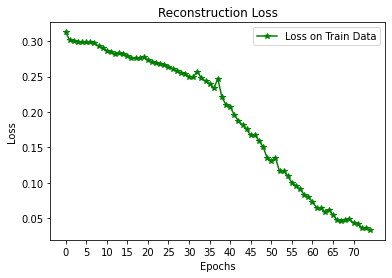

In [8]:
plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

### Visualizing Predicted and Actual Cancer mask detected from X-RAY images

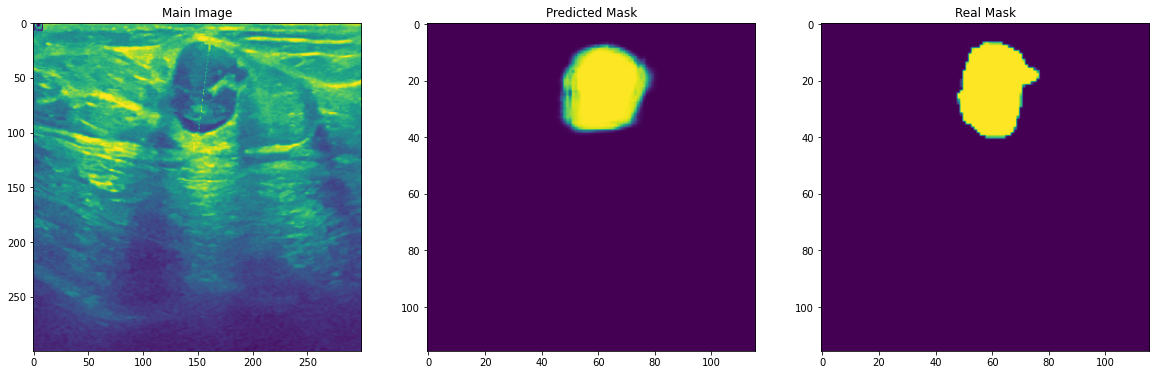

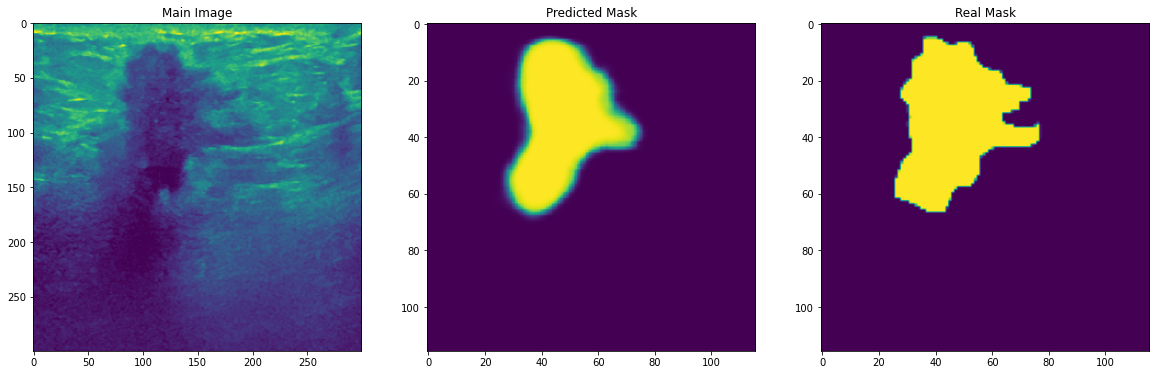

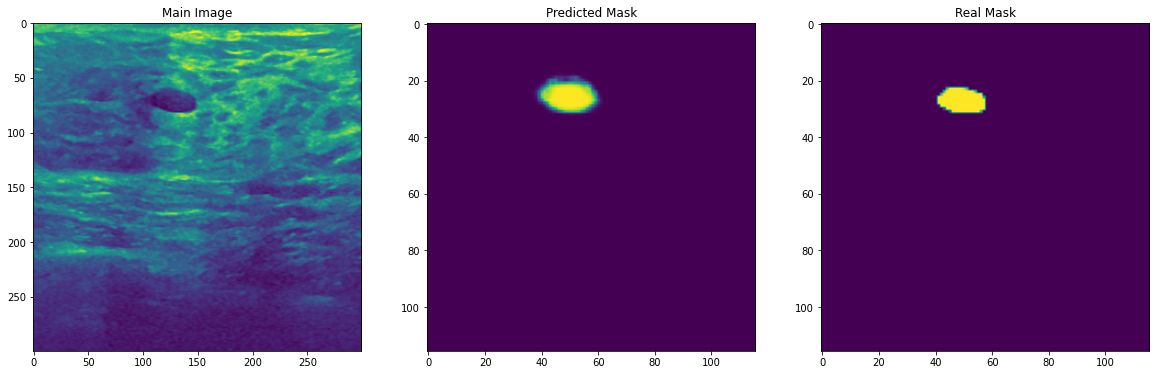

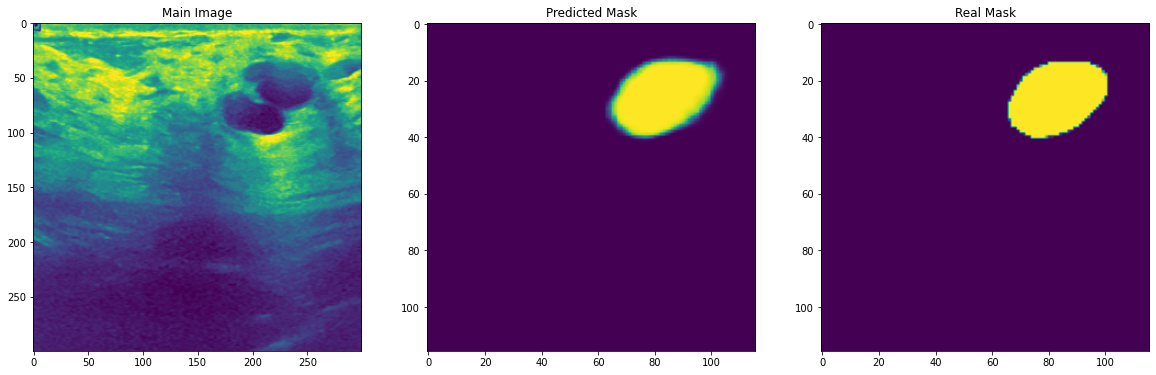

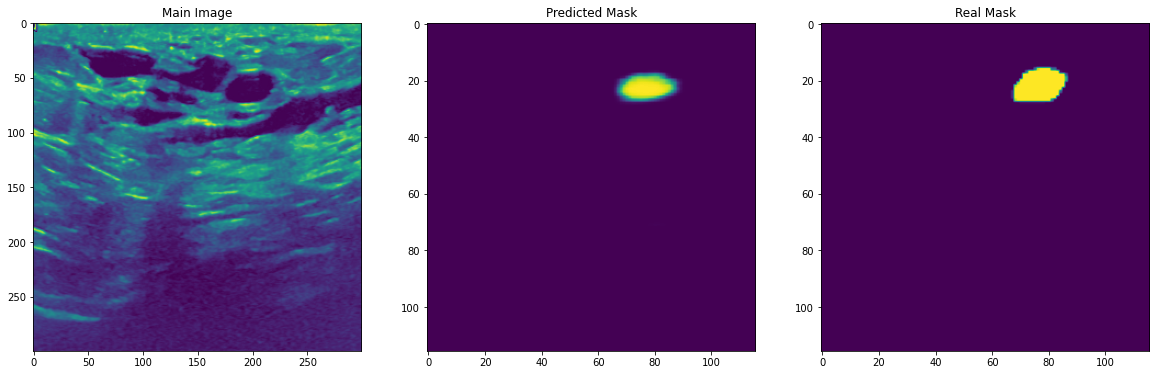

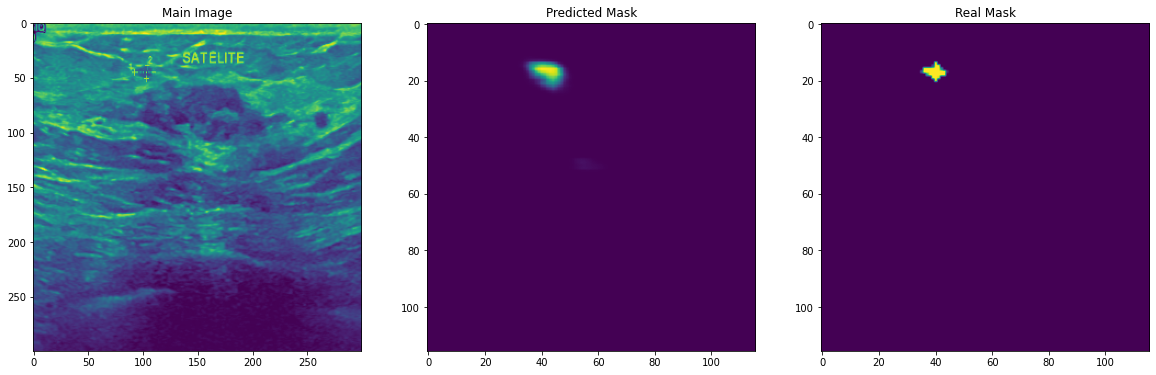

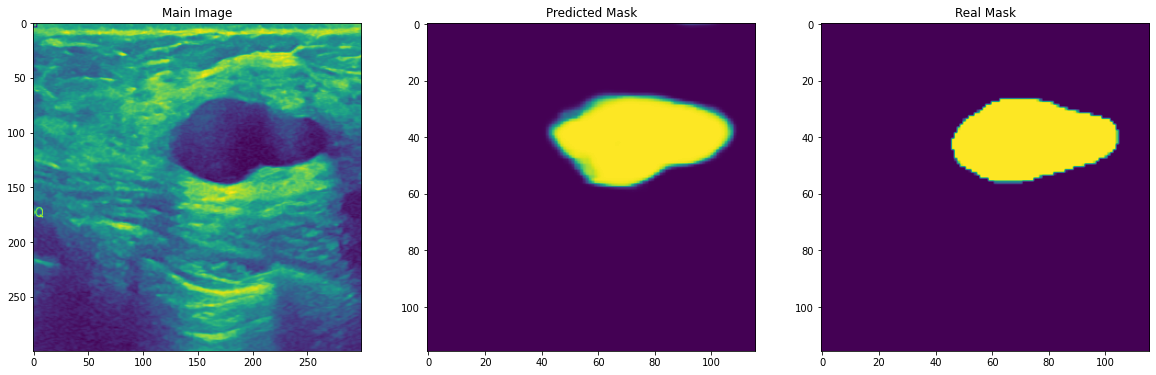

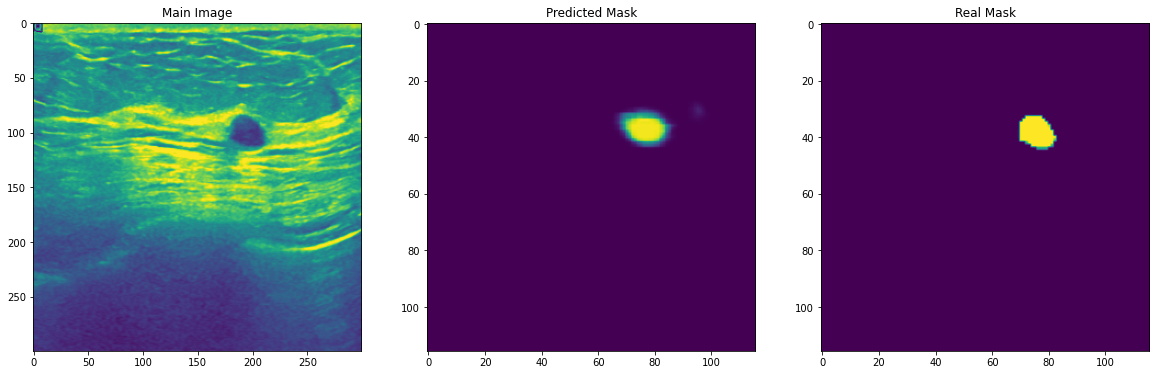

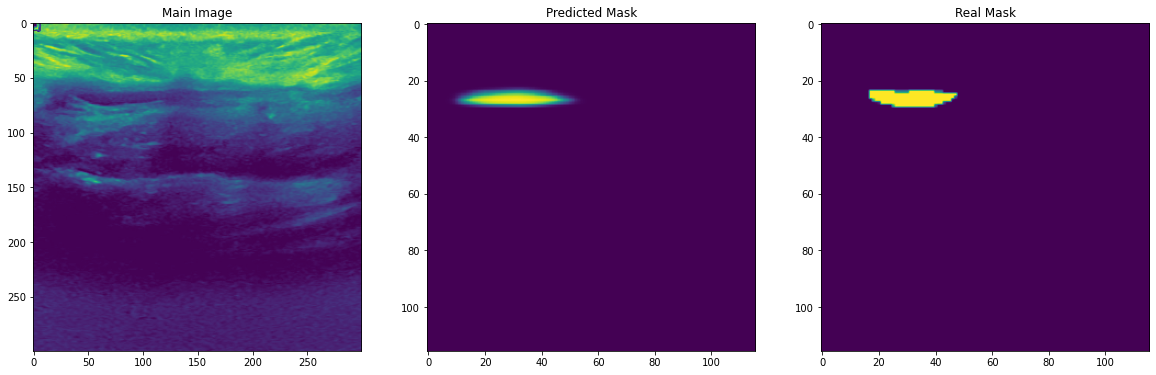

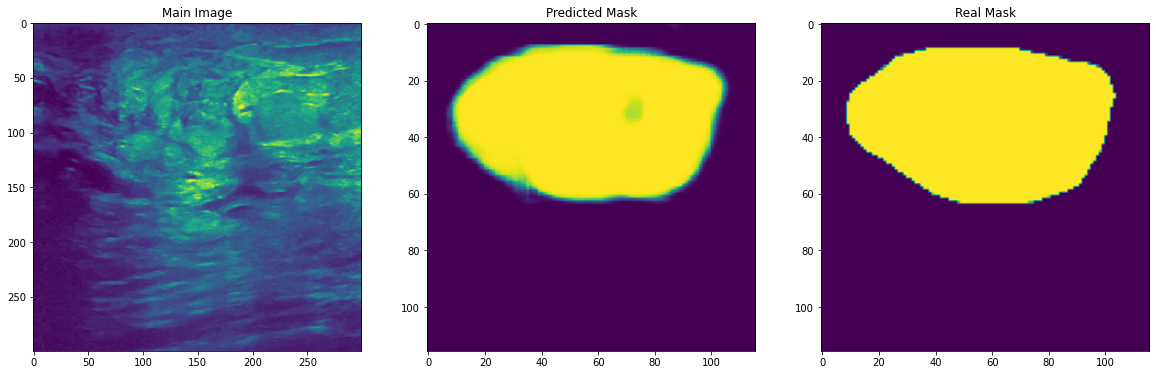

In [10]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Main Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])  
    plt.show()
    
    if i == n-1:
        break


## Classification MOdel

In [12]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [2]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import gaussian_filter

# Define an image data generator with preprocessing function
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values to [0,1]
                             width_shift_range=0.2, # randomly shift images horizontally
                             height_shift_range=0.2, # randomly shift images vertically
                             zoom_range=0.2, # randomly zoom in on images
                             horizontal_flip=True, # randomly flip images horizontally
                             vertical_flip=False, # do not randomly flip images vertically
                             validation_split=0.2
                            ) # set validation split


In [10]:
#Splitting data to validation and Training set
#Validation data = 20%
#Training Data = 80%
from tensorflow.keras.utils import image_dataset_from_directory
train_data1 = image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)


val_data1 = image_dataset_from_directory(data_dir,
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=123,
                                        image_size=(img_height,img_width),
                                        batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


In [11]:
#Importing layers and function for CNN Classififcation model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Flatten
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [12]:
#Using Transfer learning 
#Freezing the layers of the pre-trained model VGG16
#using this model for our classification task
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [13]:
#This is the top model which has flaten layers

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(BatchNormalization())
top_model.add(Dense(128, activation="relu"))
top_model.add(Dense(3, activation="softmax")) #Their are 3 nodes in the last layers as their are  3 outputs (malignant, benign, normal)

top_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 3,312,131
Trainable params: 3,261,955
Non-trainable params: 50,176
_________________________________________________________________


In [14]:
#Combining both models (top_model,base_model) for transfer learning
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(top_model)
transfer_model.layers[0].trainable = False
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 3312131   
Total params: 18,026,819
Trainable params: 3,261,955
Non-trainable params: 14,764,864
_________________________________________________________________


In [15]:
transfer_model.compile(optimizer=Adam(learning_rate=0.001), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])


In [16]:
#Fitting our transfer model for Classification
batch_size = 32

history = transfer_model.fit(train_data1,
                    epochs=5,
                    validation_data=val_data1, 
                    batch_size=32)

Epoch 1/5
40/40 [==============================] - 15s 273ms/step - loss: 1.4453 - accuracy: 0.7736 - val_loss: 1.6981 - val_accuracy: 0.7619
Epoch 2/5
40/40 [==============================] - 7s 162ms/step - loss: 0.4430 - accuracy: 0.9470 - val_loss: 1.0877 - val_accuracy: 0.8921
Epoch 3/5
40/40 [==============================] - 7s 156ms/step - loss: 0.2579 - accuracy: 0.9707 - val_loss: 0.9895 - val_accuracy: 0.9016
Epoch 4/5
40/40 [==============================] - 8s 170ms/step - loss: 0.2896 - accuracy: 0.9644 - val_loss: 1.1620 - val_accuracy: 0.8825
Epoch 5/5
40/40 [==============================] - 7s 153ms/step - loss: 0.1266 - accuracy: 0.9755 - val_loss: 1.2987 - val_accuracy: 0.8794


##  Classification Model Performance

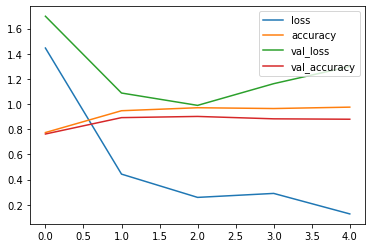

In [17]:
#Model performance
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'],loc='upper right')
plt.show()

### Plotting Those that are Classified True by the model


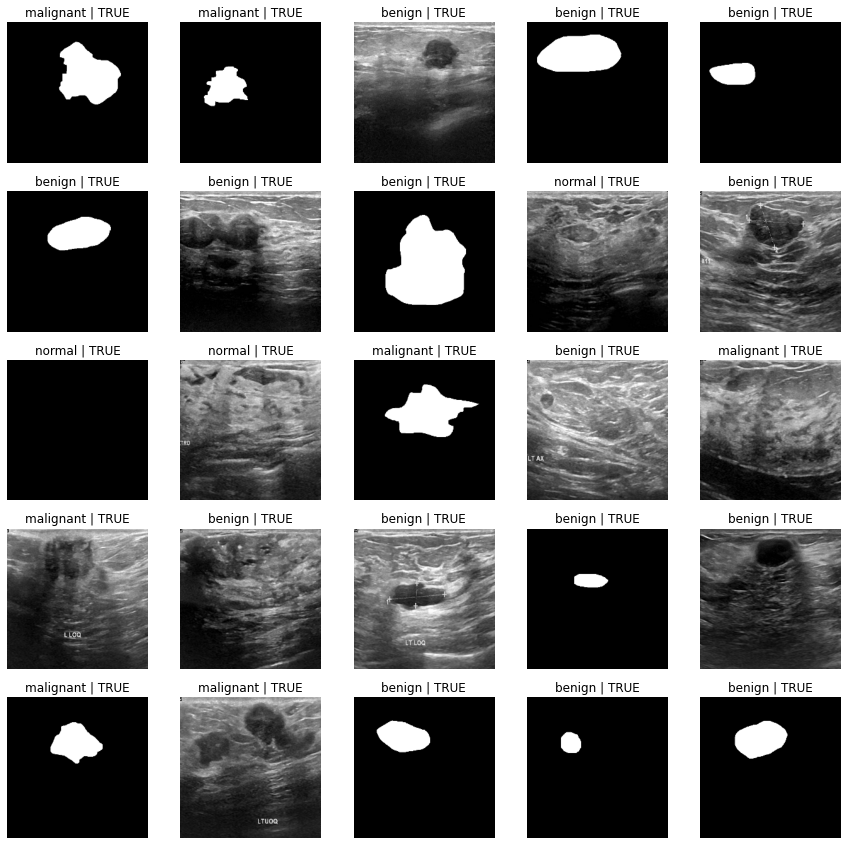

In [19]:
plt.figure(figsize=(15, 15))
class_names = val_data1.class_names
result = ' | False'
for images, labels in val_data1.take(1):
    for i in range(25):
        
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        
        predictions = transfer_model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'
            
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[predicted_class]+result  )
        plt.axis("off")

### Plotting Those that are Classified False by the model


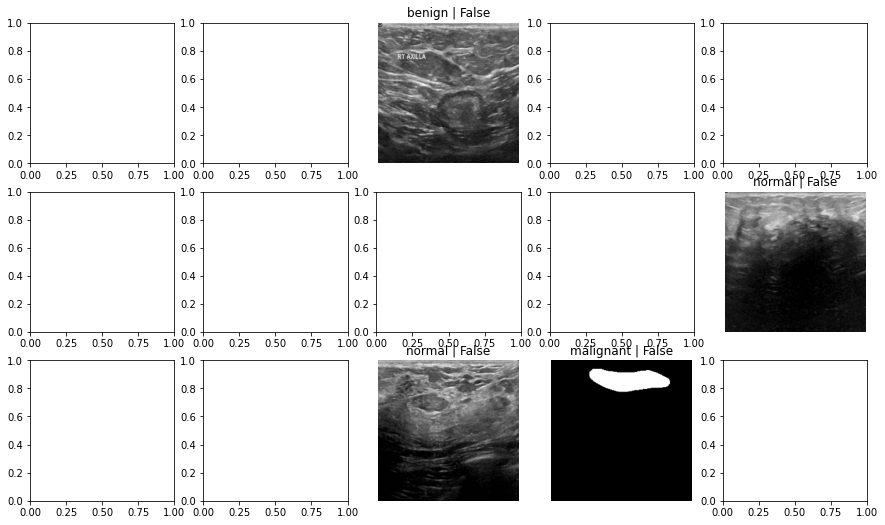

In [21]:
plt.figure(figsize=(15, 15))
class_names = val_data1.class_names
for images, labels in val_data1.take(1):
    for i in range(15):
        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)

        predictions = transfer_model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] != class_names[labels[i]]:
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[predicted_class]+' | False')
            plt.axis("off")


## Detecting cancer and Evaluating the properties  

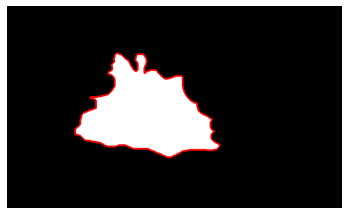

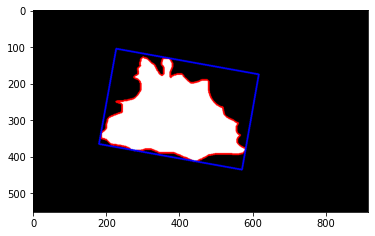

In [33]:
#Using Opencv for Feature Extraction an a Tumor in X-ray images
import matplotlib.pyplot as plt
import cv2

# File path for the image mask
img_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (102)_mask.png'
# Load the image
img = cv2.imread(img_path)

# Convert the color format from BGR to RGB
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply thresholding to create a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Find contours in the binary image
cont, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Display the image
cont_img=cv2.drawContours(img,cont,-1,255,3)

plt.imshow(cont_img)
plt.axis('off')
plt.show()


c=max(cont,key=cv2.contourArea)

rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img,[box],0,(0,0,255),3)
plt.imshow(img)

(285, 396, 3)


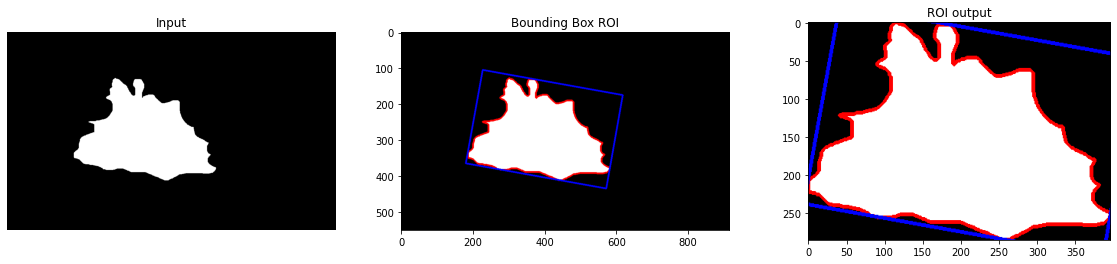

In [34]:
cropped_image=img[y:y+h,x:x+w]

#Ploting our ROI
plt.figure(figsize=(20,4))
plt.subplot(1,3,1),plt.imshow(cv2.imread(img_path)),plt.axis('off'),plt.title("Input")
plt.subplot(1,3,2),plt.imshow(img),plt.title("Bounding Box ROI")
plt.subplot(1,3,3),plt.imshow(cropped_image),plt.title("ROI output")
print(cropped_image.shape)
plt.show()

In [35]:
 # Calculate the area and perimeter of the contour
    x,y,w,h=cv2.boundingRect(c)
area = cv2.contourArea(c)
perimeter = cv2.arcLength(c, True)
 import numpy as np   
# Print the area and perimeter of the contour
print('Area:', area)
print('Perimeter:', perimeter)
print('Height:', h)
print('Width:', w)
print('Aspect Ratio:', w/h) #if value greater than 1, then tumor is maligant
form_factor=(4*np.pi*area)/(perimeter**2)
print('Form Factor:', form_factor)

Area: 63186.0
Perimeter: 1386.7148520946503
Height: 285
Width: 396
Aspect Ratio: 1.3894736842105264
Form Factor: 0.4129109434350785


In [17]:
k = cv2.isContourConvex(c)
print('Contour is Convex: ',k)
hull = cv2.convexHull(cnt)

Contour is Convex:  False


In [45]:
img_float32 = np.float32(img)
img_32f = cv2.convertScaleAbs(img_float32, alpha=(255.0/65535.0))
ret,thresh = cv2.threshold(img_32f,127,255,0)

cnt = cont[0]
M = cv2.moments(cnt)

In [49]:
# Calculate the NSPD feature
NSPD = (M['mu20'] + M['mu02']) / (M['mu20'] - M['mu02'])
# Calculate the LI feature
LI = (M['mu20'] * M['mu02'] - M['mu11'] ** 2) / (M['mu20'] + M['mu02']) ** 2
# Calculate the ENS feature
ENS = np.sqrt(M['mu20'] ** 2 + M['mu02'] ** 2) / M['m00']

print(f'NSPD: {NSPD}')
print(f'LI: {LI}')
print(f'ENS: {ENS}')

NSPD: 3.195757030073652
LI: 0.21888545485778416
ENS: 8897.439776341824


In [47]:
#Centroid
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx)
print(cy)

381
293


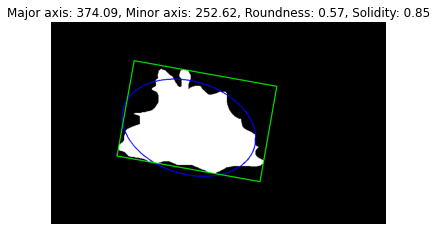

In [52]:

# File path for the image
img_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/malignant (102)_mask.png'
# Load the image
img = cv2.imread(img_path)

# Convert the color format from BGR to RGB
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply thresholding to create a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the minimum area rectangle enclosing the largest contour
largest_contour = max(contours, key=cv2.contourArea)
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Fit an ellipse around the minimum area rectangle
ellipse = cv2.fitEllipse(largest_contour)
cv2.ellipse(img, ellipse, (0, 0, 255), 2)

# Calculate the major and minor axis of the ellipse
major_axis = max(ellipse[1])
minor_axis = min(ellipse[1])

# Calculate roundness and solidity
area_contour = cv2.contourArea(largest_contour)
area_ellipse = np.pi * major_axis * minor_axis / 4
roundness = 4 * area_contour / (np.pi * pow(major_axis, 2))
solidity = area_contour / area_ellipse

# Display the image and results
cont_img = cv2.drawContours(img, [box], 0, (0, 255, 0), 2)
plt.imshow(cont_img)
plt.axis('off')
plt.title(f"Major axis: {major_axis:.2f}, Minor axis: {minor_axis:.2f}, Roundness: {roundness:.2f}, Solidity: {solidity:.2f}")
plt.show()
